ChEn-3170: Computational Methods in Chemical Engineering Fall 2018 UMass Lowell; Prof. V. F. de Almeida **03Dec2018**

# 16. T-P-Dependent Multiple Reactions at Equilibrium
$  
  \newcommand{\Amtrx}{\boldsymbol{\mathsf{A}}}
  \newcommand{\Bmtrx}{\boldsymbol{\mathsf{B}}}
  \newcommand{\Mmtrx}{\boldsymbol{\mathsf{M}}}
  \newcommand{\Imtrx}{\boldsymbol{\mathsf{I}}}
  \newcommand{\Pmtrx}{\boldsymbol{\mathsf{P}}}
  \newcommand{\Lmtrx}{\boldsymbol{\mathsf{L}}}
  \newcommand{\Umtrx}{\boldsymbol{\mathsf{U}}}
  \newcommand{\Jmtrx}{\boldsymbol{\mathsf{J}}}
  \newcommand{\Smtrx}{\boldsymbol{\mathsf{S}}}
  \newcommand{\Xmtrx}{\boldsymbol{\mathsf{X}}}
  \newcommand{\Kmtrx}{\boldsymbol{\mathsf{K}}}
  \newcommand{\xvec}{\boldsymbol{x}}
  \newcommand{\avec}{\boldsymbol{\mathsf{a}}}
  \newcommand{\bvec}{\boldsymbol{\mathsf{b}}}
  \newcommand{\cvec}{\boldsymbol{\mathsf{c}}}
  \newcommand{\rvec}{\boldsymbol{\mathsf{r}}}
  \newcommand{\mvec}{\boldsymbol{\mathsf{m}}}
  \newcommand{\gvec}{\boldsymbol{\mathsf{g}}}
  \newcommand{\zerovec}{\boldsymbol{\mathsf{0}}}
  \newcommand{\norm}[1]{\bigl\lVert{#1}\bigr\rVert}
  \newcommand{\abs}[1]{\left\lvert{#1}\right\rvert}
  \newcommand{\transpose}[1]{{#1}^\top}
  \DeclareMathOperator{\rank}{rank}
  \DeclareMathOperator{\gradx}{\nabla\!_{\xvec}}
  \newcommand{\Kcal}{\mathcal{K}}
  \newcommand{\Kcalvec}{\boldsymbol{\mathcal{K}}}
  \newcommand{\epsvec}{\boldsymbol{\varepsilon}}
$

---
## Table of Contents
* [Introduction](#intro)
* [Problem Statement](#problem)
* [Algorithm](#algo)
* [Input Data](#idata)
* [Analyze Reaction Mechanism](#analyze)
* [Single Point Equilibrium](#singlepe)
  - [Plot Equilibrium Vector Function](#eqfunc)
  - [Solve for Equilibrium](#solve)
  - [Plot Equilibrium Point](#eqpt)
* [T-P Dependent Equilibria](#tpeq)
---

## Introduction<a id="intro"></a>
It is often asked how the chemical equilibrium species molar fractions involved in a reaction mechanism vary with temperature. The answer requires the evaluation of the thermodynamic equilibrium constant, $K_{\text{a},i}$, for a given reaction using the van't Hoff equation

\begin{equation*}
\text{d}_T \ln K_{\text{a},i}= \frac{\Delta_\text{rxn} H_i(T)}{R\,T^2}
     \ \ \ \ \ \qquad \forall \ \ \ \ \ \qquad i=1,\ldots,m,
\end{equation*}

as a function of temperature using the definition

\begin{equation*}
K_{\text{a},i}(T) := \exp{\biggl(\frac{-\Delta_\text{rxn} G^\circ_i(T)}{R\,T}\biggr)}
     \ \ \ \ \ \qquad \forall \ \ \ \ \ \qquad i=1,\ldots,m,
\end{equation*}

where $\Delta_\text{rxn} G_i^\circ$ is the standard state Gibbs energy change on the reaction. The standard
state is the state of aggregation of the species involved in the reaction at the desired temperature and 
pressure of 1 bar. Here $K_{\text{a},i}$, by design, is a function of $T$ and the standard state (or state of aggregation) but not a function of pressure.

Integration of the van't Hoff equation with respect to temperature from the standard state $T=298.15$ K to any temperature $T$ gives

\begin{align*}
\ln K_{\text{a},i}(T) - \ln K_{\text{a},i}(298.15) &= 
\int\limits_{298.15}^{T} \frac{\Delta_\text{rxn} H_i(T')}{R\,T'^2} \, \text{d}T' 
     \ \ \ \ \ \qquad \forall \ \ \ \ \ \qquad i=1,\ldots,m,
\\
\ln K_{\text{a},i}(T) &= \ln K_{\text{a},i}(298.15)  + \int\limits_{298.15}^{T} \frac{\Delta_\text{rxn} H_i(T')}{R\,T'^2} \, \text{d}T' 
     \ \ \ \ \ \qquad \forall \ \ \ \ \ \qquad i=1,\ldots,m,
\\
K_{\text{a},i}(T) &= K_{\text{a},i}(298.15) \, \exp\biggl( \int\limits_{298.15}^{T} \frac{\Delta_\text{rxn} H_i(T')}{R\,T'^2} \, \text{d}T' \biggr)
     \ \ \ \ \ \qquad \forall \ \ \ \ \ \qquad i=1,\ldots,m,
\\
K_{\text{a},i}(T) &= \exp{\biggl(\frac{-\Delta_\text{rxn} G^\circ_i(298.15)}{R\,298.15}\biggr)} \, \exp\biggl( \int\limits_{298.15}^{T} \frac{\Delta_\text{rxn} H_i(T')}{R\,T'^2} \, \text{d}T' \biggr)
     \ \ \ \ \ \qquad \forall \ \ \ \ \ \qquad i=1,\ldots,m .
\end{align*}

In [1]:
'''Equilibrium constant K_ai(T)'''

def k_a_cte( temp, delta_rxn_g_std_state_vec, delta_rxn_h_std_state_func_vec ):
    
    assert temp > 0.0
    n_reactions = delta_rxn_g_std_state_vec.size
    assert delta_rxn_h_std_state_func_vec.size == n_reactions
    
    from scipy.constants import gas_constant as r_gas # J/mol/K
    from scipy.constants import calorie as calorie
    
    r_gas /= calorie # cal/mol/K
    
    import math
    import numpy as np
    
    k_a_298_vec = np.exp(-delta_rxn_g_std_state_vec/r_gas/298.15)
    
    k_a_cte_vec = np.zeros(n_reactions)
    
    import scipy.integrate as integrate
    for i in range(n_reactions):
        # quad returns a pair (integral,accuracy)
        integral = integrate.quad(lambda T: delta_rxn_h_std_state_func_vec[i](T)/r_gas/T/T, 298.15, temp)
        integral_error = integral[1]
        assert abs(integral_error) <= 1e-5
    
        k_a_cte_vec[i] = k_a_298_vec[i] * math.exp( integral[0] )
    
    return k_a_cte_vec

The statement of chemical equilibrium obtained from the energy and entropy balance for a closed system is

\begin{equation*}
K_{\text{a},i}(T) = \prod\limits_{j=1}^{n}\, a_j^{S_{i,j}}
     \ \ \ \ \ \qquad \forall \ \ \ \ \ \qquad i=1,\ldots,m ,
\end{equation*}

where $a_j$ is the standard-state activity of the $j$th species which is a function of temperature, pressure, and standard state. For low and moderate pressure gas mixtures the activity is approximated by

\begin{equation*}
a_j = \frac{x_j\,P}{P^\circ} ,
\end{equation*}

where $x_j$ is the species molar fraction and $P^\circ = 1 \text{bar}$ is the standard state pressure. In this limit of pressure, the chemical equilibrium gives

\begin{equation*}
K_{\text{a},i}(T) = \Bigl({\frac{P}{P^\circ}}\Bigr)^{\sum_j S_{i,j}} \, \prod\limits_{j=1}^{n}\, x_j^{S_{i,j}} 
     \ \ \ \ \ \qquad \forall \ \ \ \ \ \qquad i=1,\ldots,m .
\end{equation*}

Again the left side of the equilibrium statement is only a function of temperature. Pressure is accounted for in the equilibrium through the activities of the species. If the $i$th reaction conserves moles then $\sum_j S_{i,j}=0$ and theres is no depedency on pressure at low to moderate pressures.

Equivalently, the chemical equilibrium statement can be written as

\begin{equation*}
\Bigl({\frac{P}{P^\circ}}\Bigr)^{-\sum_j S_{i,j}} \, K_{\text{a},i}(T) = \prod\limits_{j=1}^{n}\, x_j^{S_{i,j}} 
     \ \ \ \ \ \qquad \forall \ \ \ \ \ \qquad i=1,\ldots,m ,
\end{equation*}

where using the molar fraction equilibrium function $K_{x,i}(T,P)$ produces the form

\begin{equation*}
K_{x,i}(T,P) = \prod\limits_{j=1}^{n}\, x_j^{S_{i,j}} 
     \ \ \ \ \ \qquad \forall \ \ \ \ \ \qquad i=1,\ldots,m ,
\end{equation*}

with the definition

\begin{equation*}
K_{x,i}(T,P) := \Bigl({\frac{P}{P^\circ}}\Bigr)^{-\sum_j S_{i,j}} \, K_{\text{a},i}(T) .
\end{equation*}



In [2]:
'''Molar equilibrium constant K_xi(T,P)'''

def k_x_cte( pressure, stoic_mtrx, k_a_cte_vec ):
    
    assert temp > 0.0
    assert pressure > 0.0
    
    n_reactions = stoic_mtrx.shape[0]
    assert k_a_cte_vec.size == n_reactions
    
    import numpy as np
    k_x_cte_vec = np.zeros(n_reactions)
    for i in range(n_reactions):
        k_x_cte_vec[i] = pressure**(-stoic_mtrx[i,:].sum()) * k_a_cte_vec[i]
    
    return k_x_cte_vec

## Problem Statement<a id="problem"></a>
Determine the equilibrium compositions at pressures of 1 bar, 2 bar, and 3 bar, and varying temperature from 800 K to 2000 K for a pure stream of ethane. Discuss the results for simultaneous production of ethylene and acetylene from ethane.


| Ethylene and Acetylene from Ethane   | $\Delta_\text{rxn} H^\circ(T)$ [cal/mol] (T in K)| $\Delta_\text{rxn} G^\circ(298.15 K)$ [cal/mol] |
|:--------------------------------------:|:-:|:-----------------------------------------------:|
|C2H6 <=> C2H4 +   H2                  | $31\,094 + 6.101\,T - 1.46\times 10^{-3}\,T^2 -2.222\times 10^{-6}\,T^3 + 9.843\times 10^{-10}\,T^4$ | 24 142 |
|C2H6 <=> C2H2 + 2 H2                  | $69\,936 + 18.082\,T - 10^{-2}\,T^2 -6.617\times 10^{-7}\,T^3 + 1.236\times 10^{-9}\,T^4$ | 57 860 |
|C2H4 <=> C2H2 +   H2                  | $38\,842 + 11.981\,T - 8.546\times 10^{-3}\,T^2 +1.561\times 10^{-6}\,T^3 + 2.517\times 10^{-10}\,T^4$ | 33 718 |



## Algorithm<a id="algo"></a>

Through Newton's method the roots of multiple non-linear equations, $\Kcal\bigl(\xvec(\widehat{\epsvec})\bigr)=0$ can be computed for varying pressures and temperatures.
In this case we write the equilibrium functions as a vector with components

\begin{equation*}
\Kcal_i\bigl(\xvec\bigr)= K_{x,i}(T,P) - \prod\limits_{j=1}^n\, x_j^{S_{i,j}} = 0,
    \ \ \ \ \ \qquad \forall \ \ \ \ \ \qquad i=1,\ldots,m
\end{equation*}

where $i$ is the index of each reaction.

In [3]:
'''Equilibrium function vector'''

def keq_function( x_vec, k_x_cte_vec, stoic_mtrx ):
    
    n_reactions = k_x_cte_vec.size
    n_species   = x_vec.size
    
    assert n_reactions == stoic_mtrx.shape[0]
    assert n_species   == stoic_mtrx.shape[1]
    
    prod_vec = np.ones(n_reactions,dtype=np.float64)
    
    for i in range(n_reactions):
        for j in range(n_species):
            prod_vec[i] *= x_vec[j]**stoic_mtrx[i,j]
       
    keq_vec = k_x_cte_vec - prod_vec
    
    return keq_vec

The molar fractions vector is a function of the normalized extent of reactions vector

\begin{equation*}
\xvec(\widehat{\epsvec}) = \frac{\xvec^{(0)} + \Smtrx^\top\widehat{\epsvec}\,}{1+\sum\limits_j (\Smtrx^\top\widehat{\epsvec})_j} ,
\end{equation*}

where $\xvec^{(0)}$ is the vector of initial molar fractions (or reference).

In [82]:
'''Molar fractions function'''

def molar_fractions( ext_hat_vec, x_vec_0, stoic_mtrx ):
    
    import numpy as np
    assert abs(x_vec_0.sum()-1.0) <= 1e-10
    assert np.all(x_vec_0>=0.0)
    assert np.all(np.abs(ext_hat_vec)>=0.0),'ext_hat_vec=%r'%ext_hat_vec
    
    denom = 1.0 + (stoic_mtrx.transpose()@ext_hat_vec).sum()
    assert abs( denom ) >= 1e-9,'denom=%r; ext_hat_vec=%r; x_vec_0=%r'%(denom,ext_hat_vec,x_vec_0)
    
    x_vec = ( x_vec_0 + stoic_mtrx.transpose()@ext_hat_vec ) / denom
    
    return x_vec

The usage of Newton's method to compute an equilibrium molar fraction solution vector requires the value of 
$\Kcalvec\bigl(\xvec(\widehat{\epsvec})\bigr)$ at different values of $\widehat{\epsvec}$ and the total derivative

\begin{equation*}
d_{\widehat{\epsvec}} \Kcalvec\bigl(\xvec(\widehat{\epsvec})\bigr) = 
                       \gradx\Kcalvec \, d_{\widehat{\epsvec}}\xvec ,
\end{equation*}

which is matrix product. The molar fraction gradient is computed as a product of three matrices

\begin{equation*}
 \gradx\Kcal = - \Kmtrx\,\Smtrx\,\Xmtrx^{-1} ,
\end{equation*}

that is,

\begin{equation*}
 \Kmtrx = 
  \begin{pmatrix}
   K_{x,1} & 0       & \dots  & 0      \\
   0       & K_{x,2} & \dots  & 0      \\
   \vdots  & \vdots  & \ddots & \vdots \\
   0       & 0       & \dots  & K_{x,m}
\end{pmatrix}, 
\ \ \ 
\Smtrx = 
\begin{pmatrix}
S_{1,1} & S_{1,2} & \dots  & S_{1,n} \\
S_{2,1} & S_{2,2} & \dots  & S_{2,n} \\
\vdots  & \vdots  & \ddots & \vdots \\
S_{m,1} & S_{m,2} & \dots  & S_{m,n}
\end{pmatrix},
\ \ \ 
 \Xmtrx = 
  \begin{pmatrix}
   x_1 & 0       & \dots  & 0      \\
   0       & x_2 & \dots  & 0      \\
   \vdots  & \vdots  & \ddots & \vdots \\
   0       & 0       & \dots  & x_n
\end{pmatrix} .
%
\end{equation*}

In [5]:
'''Gradient wrt to molar fractions of the equilibrium function'''

def grad_x_k_function( x_vec, keq_cte_vec, stoic_mtrx ):
    
    import numpy as np
    
    # build the K matrix
    k_mtrx = np.diag(keq_cte_vec)
    
    # correct for division by a very small number
    import numpy as np
    x_vec_local = np.copy(x_vec)
    
    max_x = x_vec_local.max()
    for i in range(x_vec_local.size):
        if x_vec_local[i] < 1e-8:
            x_vec_local[i] = max_x # some reasonable mole fraction
            
    x_vec_inv = 1.0/x_vec_local
    x_mtrx_inv = np.diag(x_vec_inv)
    
    grad_mtrx = - k_mtrx @ stoic_mtrx @ x_mtrx_inv
    
    return grad_mtrx

The molar fraction derivative is

\begin{equation*}
d_{\widehat{\epsvec}}\xvec = \frac{\Smtrx^\top}{1+\sum_j (\Smtrx^\top\widehat{\epsvec})_j} -
                             \frac{\bigl(\xvec^{(0)} + \Smtrx^\top\widehat{\epsvec}\bigr)\otimes\bigl(\sum_j\Smtrx^\top_{j,\bullet}\bigr)}{\bigl(1+\sum_j (\Smtrx^\top\widehat{\epsvec})_j\bigr)^2}
\end{equation*}

In [6]:
'''Derivative of the molar fractions function wrt normalized extent of reaction'''

def d_ext_molar_fractions( ext_hat_vec, x_vec_0, stoic_mtrx ):
    
    denom  = 1.0 + (stoic_mtrx.transpose()@ext_hat_vec).sum()
    denom2 = denom**2
    
    dext_x_vec =  stoic_mtrx.transpose() / denom \
                -  np.outer( x_vec_0 + stoic_mtrx.transpose()@ext_hat_vec, (stoic_mtrx.transpose()).sum(0) ) / \
                   denom2
    
    return dext_x_vec

## Algorithm<a id="algo"></a>

Given $\Kcalvec\bigl(\xvec(\widehat{\epsvec})\bigr)$, find the root

\begin{equation*}
\Kcalvec\bigl(\xvec(\widehat{\epsvec})\bigr) = 0 ,
\end{equation*}

using an iterative method based on the initial guess $\widehat{\epsvec}_0$.
Compute the updates

\begin{equation*}
d_{\widehat{\epsvec}} \Kcalvec\bigl(\xvec(\widehat{\epsvec})\bigr) \, \delta \widehat{\epsvec}_k = - \Kcalvec\bigl(\xvec(\widehat{\epsvec}_{k-1})\bigr) 
                                     \ \qquad \  \forall \ \qquad \ k = 1,\ldots,k_\text{max} , 
\end{equation*}

then compute the approximation to the root

\begin{equation*}
 \widehat{\epsvec}_k = \widehat{\epsvec}_{k-1} + \delta \widehat{\epsvec}_k \ \qquad \  \forall \ \qquad\ \ k = 1,\ldots,k_\text{max} ,
\end{equation*}

until convergence, say, $\norm{\delta\widehat{\epsvec}_k} \le 10^{-8}$ and $\norm{\Kcal\bigl(\xvec(\widehat{\epsvec}_k)\bigr)} \le 10^{-8}$, or no convergence achieved , say $k>k_\text{max}$. 

In [115]:
"""Newton's method"""

def newton_solve( x_vec_0, k_x_cte_vec, stoic_mtrx,
                  ext_hat_vec_0=None, k_max=30, tolerance=1.0e-10, verbose=True ):

    #from chen_3170.toolkit import solve
    
    import numpy as np
    if ext_hat_vec_0 is None:
        ext_hat_vec_0 = np.zeros(k_x_cte_vec.size,dtype=np.float64)
    
    # Other initialization
    delta_vec_k = 1e+10 * np.ones(ext_hat_vec_0.size,dtype=np.float64)
    keq_vec_k   = 1e+10 * np.ones(ext_hat_vec_0.size,dtype=np.float64) # equilibrium function initial value
    ext_hat_vec = np.copy(ext_hat_vec_0)

    if verbose is True:
        print('\n')
        print('******************************************************')
        print("          Newton's Method Iterations                  ")
        print('******************************************************')
        print("k |  K(e_k)  |  K'(e_k) | |del e_k| |    e_k   |convg|")
        print('------------------------------------------------------')

    import math
    k = 0
    
    while (np.linalg.norm(delta_vec_k) > tolerance or np.linalg.norm(keq_vec_k) > tolerance) and k <= k_max:
        
        # compute the molar fractions
        x_vec = molar_fractions( ext_hat_vec, x_vec_0, stoic_mtrx ) 
        
        # compute the equilibrium function
        keq_vec_k = keq_function( x_vec, k_x_cte_vec, stoic_mtrx )
        
        # copute the molar fraction gradient of the equilibrium function
        grad_x_k = grad_x_k_function( x_vec, k_x_cte_vec, stoic_mtrx )
        
        # compute the extent of reaction derivative of the molar fraction
        d_ext_x = d_ext_molar_fractions( ext_hat_vec, x_vec_0, stoic_mtrx )
        
        # form the total derivative of the equilibrium function wrt the extent of reaction
        d_ext_keq_k = grad_x_k @ d_ext_x # Jacobian matrix
        
        # compute the Newton update    
        delta_vec_k_old = delta_vec_k
        a_mtrx = d_ext_keq_k
        b_vec  = - keq_vec_k
        
        #delta_vec_k = solve(a_mtrx, b_vec, zero_tol=1e-8)
        delta_vec_k = np.linalg.solve(a_mtrx, b_vec) # using scipy linear solver
        
        # compute the update to the root candidate
        ext_hat_vec += delta_vec_k
        
        if k > 0:
            if np.linalg.norm(delta_vec_k) != 0.0 and np.linalg.norm(delta_vec_k_old) != 0.0:
                convergence_factor = math.log(np.linalg.norm(delta_vec_k),10) / math.log(np.linalg.norm(delta_vec_k_old),10)
            else:
                convergence_factor = 0.0  
        else:
            convergence_factor = 0.0
            
        k = k + 1
        
        if verbose is True:
            print('%2i %+5.3e %+5.3e %+5.3e  %+5.3e %5.2f'%\
                  (k,np.linalg.norm(keq_vec_k),np.linalg.norm(d_ext_keq_k),np.linalg.norm(delta_vec_k),np.linalg.norm(ext_hat_vec),convergence_factor))

    if verbose is True:
        print('******************************************************') 
        print('Root = ',ext_hat_vec)
    
    return ext_hat_vec

## Input Data<a id="idata"></a>

Using the ethylene-acetylene from ethane reaction mechanism from the input file: `data/ethylene-acetylene-rxn2.txt` 

In [242]:
!cat data/ethylene-acetylene-rxn2.txt

#
# Production of ethylene and acetylene from ethane
#
..str:float:str
C2H6 <=> C2H4 +   H2  : DeltaGstd = 24142 : DeltaHstd(T) = 31094+6.101*T-1.46e-3*T**2-2.222e-6*T**3+9.843e-10*T**4
C2H6 <=> C2H2 + 2 H2  : DeltaGstd = 57860 : DeltaHstd(T) = 69936+18.082*T-1.0e-2*T**2-6.617e-7*T**3+1.236e-9*T**4
C2H4 <=> C2H2 +   H2  : DeltaGstd = 33718 : DeltaHstd(T) = 38842+11.981*T-8.546e-3*T**2+1.561e-6*T**3+2.517e-10*T**4


In [243]:
'''Import the ethylene-acetylene from ethane reaction mechanism'''

try:    
    from chen_3170.toolkit import reaction_mechanism   
except ModuleNotFoundError:
    assert False, 'You need to provide your own reaction_mechanism function here. Bailing out.'
    
# read species, reactions, equilibrium constants and build the stoichiometric matrix
(species, reactions, stoic_mtrx, delta_rxn_g_std_state, delta_rxn_h_std_state) = reaction_mechanism('data/ethylene-acetylene-rxn2.txt',shuffle=False)


species= ['C2H2', 'C2H4', 'C2H6', 'H2']

r0 :  C2H6 <=> C2H4 +   H2
r1 :  C2H6 <=> C2H2 + 2 H2
r2 :  C2H4 <=> C2H2 +   H2
n_reactions = 3

matrix shape = (3, 4)


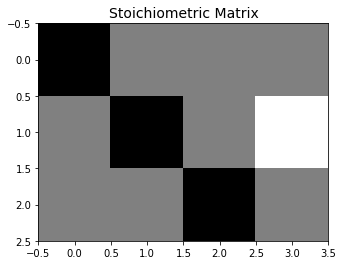


stoic_mtrx=
 [[ 0.  1. -1.  1.]
 [ 1.  0. -1.  2.]
 [ 1. -1.  0.  1.]]


In [244]:
'''Info on the data'''

print('species=',species)
from chen_3170.help import print_reactions
print('')
print_reactions(reactions) 
print('')
from chen_3170.help import plot_matrix
plot_matrix(stoic_mtrx, title='Stoichiometric Matrix')
print('')
import numpy as np
np.set_printoptions(precision=3,threshold=100,edgeitems=5)
print('stoic_mtrx=\n',stoic_mtrx)

In [245]:
'''Create reactions energy deltas'''

import numpy as np

# Gibb's energy of reaction
delta_rxn_g_std_state_vec = np.array(delta_rxn_g_std_state)

# Enthalpy of reaction functions
delta_rxn_h_std_state_func_lst = list()
for string in delta_rxn_h_std_state:
    delta_rxn_h_std_state_func_lst.append( eval('lambda T:'+string) )
delta_rxn_h_std_state_func_vec = np.array(delta_rxn_h_std_state_func_lst)

The following reference molar fraction $\xvec^{(0)}$ is given:

|  Reference Molar Fraction |    Parameter    | Value |
|:--------------------------|:---------------:|:-----:|
| C2H6                      | $x_\text{C2H6}$ | 1.0   |
| C2H4                      | $x_\text{C2H4}$ | 0.0   |
| C2H2                      | $x_\text{C2H2}$ | 0.0   |
| H2                        | $x_\text{H2}$   | 0.0   |

In [246]:
'''Set reference molar fraction'''

import numpy as np
x_dict_0 = {'C2H6':1.0,'C2H4':0.0,'C2H2':0.0,'H2':0.0}

## Analyze Reaction Mechanism<a id="analyze"></a>

In [247]:
'''Check the rank of the stoichiometric matrix'''

try:    
    from chen_3170.toolkit import matrix_rank    
except ModuleNotFoundError:
    assert False, 'You need to provide your own matrix_rank function here. Bailing out.'

rank = matrix_rank( stoic_mtrx )
print('stoic_mtrx m x n =',stoic_mtrx.shape)
print('stoic_mtrx rank =',rank)

stoic_mtrx m x n = (3, 4)
stoic_mtrx rank = 2


In [248]:
'''Build the full-rank sub-mechanism reactions list'''

try:    
    from chen_3170.toolkit import sub_mechanisms    
except ModuleNotFoundError:
    assert False, 'You need to provide your own sub_mechanisms function here. Bailing out.'

sub_mechanisms = sub_mechanisms( species, reactions, stoic_mtrx )

# reactions =  3
# species   =  4
rank of S =  2
# of all possible sub_mechanisms = 3
# of full-rank sub_mechanisms = 3


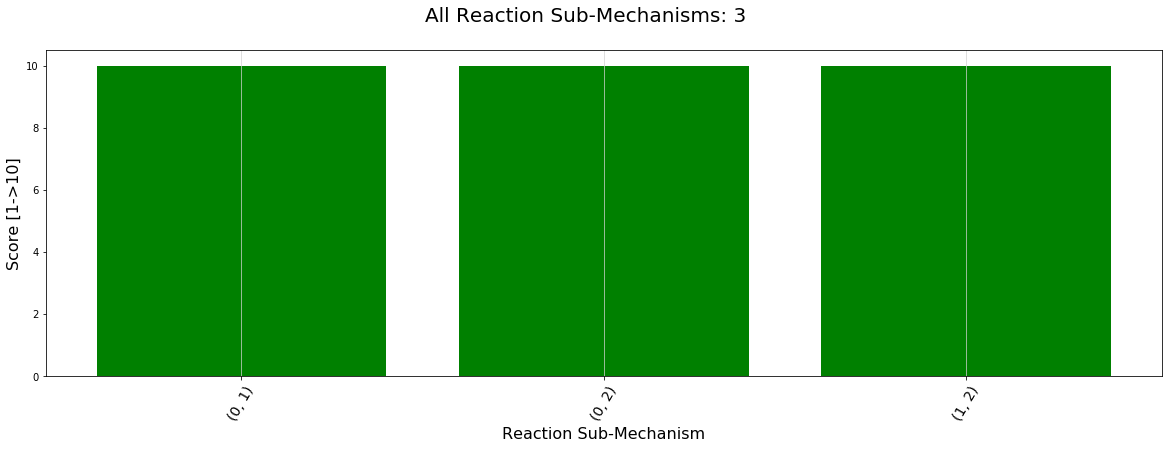

In [249]:
'''Plot full-rank sub-mechanism reactions list'''

try:    
    from chen_3170.toolkit import plot_reaction_mechanisms    
except ModuleNotFoundError:
    assert False, 'You need to provide your own plot_reaction_mechanisms function here. Bailing out.'
    
plot_reaction_mechanisms( sub_mechanisms )

## Single Point Equilibrium<a id="singlepe"></a>

Fixed $T$, $P$ equilibrium using the first sub-mechanism. 

In [250]:
pressure = 1.0  # bar
temp     = 800  # K

Select a reaction sub-mechanism; any sub-mechanism will do it but the initial guess for the extent of reaction in Newton's method will be critical depending on the choice of sub-mechanism. Just by inspecting the reaction sub-mechanisms and given the pure initial stream of ethane, one can guess the difficulty of finding a good initial guess.

In [251]:
'''Select a sub-mechanism'''

sub_mechanism_id = 2

sub_mechanism = sub_mechanisms[sub_mechanism_id]
print('species=',species)
for i in sub_mechanism:
    print(i)

species= ['C2H2', 'C2H4', 'C2H6', 'H2']
(1, 2)
['C2H6 <=> C2H2 + 2 H2', 'C2H4 <=> C2H2 +   H2']
[[ 1.  0. -1.  2.]
 [ 1. -1.  0.  1.]]
10.0


In [252]:
'''Setup a sub-mechanism'''

reaction_ids = sub_mechanism[0]
reactions    = sub_mechanism[1]
stoic_mtrx   = sub_mechanism[2]

print('species=',species)
print('')
print('reaction ids=',reaction_ids)
print('')
print_reactions(reactions) 
print('')
import numpy as np
np.set_printoptions(precision=3,threshold=100,edgeitems=5)
print('stoic_mtrx=\n',stoic_mtrx)

delta_rxn_g_std_state_vec      = delta_rxn_g_std_state_vec[np.array(reaction_ids)]
delta_rxn_h_std_state_func_vec = delta_rxn_h_std_state_func_vec[np.array(reaction_ids)]

print('')
print('delta_rxn_g_std_state_vec=',delta_rxn_g_std_state_vec)
print('')
print('delta_rxn_h_std_state=',delta_rxn_h_std_state)

species= ['C2H2', 'C2H4', 'C2H6', 'H2']

reaction ids= (1, 2)

r0 :  C2H6 <=> C2H2 + 2 H2
r1 :  C2H4 <=> C2H2 +   H2
n_reactions = 2

stoic_mtrx=
 [[ 1.  0. -1.  2.]
 [ 1. -1.  0.  1.]]

delta_rxn_g_std_state_vec= [57860. 33718.]

delta_rxn_h_std_state= ['31094+6.101*T-1.46e-3*T**2-2.222e-6*T**3+9.843e-10*T**4', '69936+18.082*T-1.0e-2*T**2-6.617e-7*T**3+1.236e-9*T**4', '38842+11.981*T-8.546e-3*T**2+1.561e-6*T**3+2.517e-10*T**4']


In [253]:
'''Setup a sub-mechanism'''

x_vec_0 = np.zeros(len(species),dtype=np.float64)
for i in range(len(species)):
    x_vec_0[i] = x_dict_0[species[i]]
    
assert abs(np.sum(x_vec_0) - 1.0) <= 1e-12
assert np.all(x_vec_0 >=0.0)

k_a_cte_vec = k_a_cte( temp, delta_rxn_g_std_state_vec, delta_rxn_h_std_state_func_vec )
print('k_a_cte_vec =',k_a_cte_vec)

k_x_cte_vec = k_x_cte( pressure, stoic_mtrx, k_a_cte_vec )
print('k_x_cte_vec =',k_x_cte_vec)

k_a_cte_vec = [3.581e-08 7.852e-06]
k_x_cte_vec = [3.581e-08 7.852e-06]


## Plot Equilibrium Vector Function<a id="eqfunc"></a>

Plot equilibrium vector function for the first sub-mechanism. 

In [254]:
'''Function: plot equilibrium function'''

def plot_keq_function( ext_hat_vec_min, ext_hat_vec_max, num_pts,
                       x_vec_0, k_x_cte_vec, stoic_mtrx,
                       ext_hat_vec_root=None  ):
    
    import matplotlib.pyplot as plt
    plt.figure(1, figsize=(25, 5))
    
    # number of functions to be plotted
    num_keq_functions = k_x_cte_vec.size
    
    import numpy as np
    
    # allocate a matrix for all ext_hat_vec plot points (min to max)
    ext_hat_plot_pts = np.zeros((num_pts,num_keq_functions))
    
    # create all plot points for ext_hat_vec
    for i in range(num_keq_functions):
        ext_hat_plot_pts[:,i] = np.linspace(ext_hat_vec_min[i], ext_hat_vec_max[i], num_pts)
    
    # allocate a matrix for all keq_function_vec plot points
    keq_function_plot_values = np.zeros((num_pts,num_keq_functions))
    
    # create all plot points for keq_function
    for i in range(num_keq_functions):
    
        for k in range(num_pts):
            x_vec = molar_fractions( ext_hat_plot_pts[k,:], x_vec_0, stoic_mtrx ) 
            keq_function_plot_values[k,:] = keq_function( x_vec, k_x_cte_vec, stoic_mtrx )
    
    # Plot keq_function_vec in subplots
    n_rows = 1
    n_columns = num_keq_functions 
    # create colors for each equilibrium function
    from chen_3170.help import color_map
    colors = color_map(num_keq_functions)
    for iplot in range(num_keq_functions):
        plt.subplot(n_rows,n_columns, iplot+1)
        color = colors[iplot]
        plt.plot(ext_hat_plot_pts[:,iplot], keq_function_plot_values[:,iplot],
                 color=color,label='$K_{x,%i}=$%8.2e'%(reaction_ids[iplot],k_x_cte_vec[iplot]))
    
        plt.xlabel(r'$\hat{\varepsilon}_{%i}$'%reaction_ids[iplot],fontsize=18)
        plt.ylabel(r'$K_{%i}(\hat{\varepsilon})$'%reaction_ids[iplot],fontsize=18)
        plt.title(reactions[iplot],fontsize=20)
        plt.legend(loc='best',fontsize=12)
        plt.xticks(fontsize=16)
        plt.yticks(fontsize=16)
    
        (x_min,x_max) = plt.xlim()
        dx = abs(x_max-x_min)
        x_text = x_max+dx*1/100
    
        (y_min,y_max) = plt.ylim()
        dy = abs(y_max-y_min)
        y_text = y_max - dy*0.1
    
        for x,spc in zip(x_vec_0,species):
            plt.text(x_text, y_text, r'$x_{%s}^{(0)}=$%8.2e'%(spc,x),fontsize=16)
            y_text -= dy*0.15
    
        if ext_hat_vec_root is not None:
            
            e_root = ext_hat_vec_root[iplot]
            plt.plot(e_root, 0.0,'r*',label='root',markersize=14)
               
            (x_min,x_max) = plt.xlim()
            dx = abs(x_max-x_min)
            x_text = e_root + dx*0.01
    
            (y_min,y_max) = plt.ylim()
            dy = abs(y_max-y_min)
            y_text = 0.0 + dy*0.01
    
            plt.text(x_text, y_text, r'$\hat{\varepsilon}^*=$%8.2e'%e_root,fontsize=16)
       
        plt.grid(True)
        plt.show()
        print('')
    
    return

/Users/valmor_dealmeida/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: divide by zero encountered in double_scalars
  from ipykernel import kernelapp as app


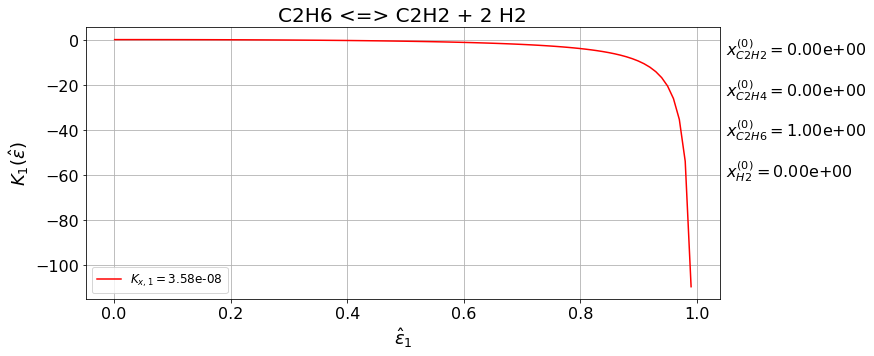

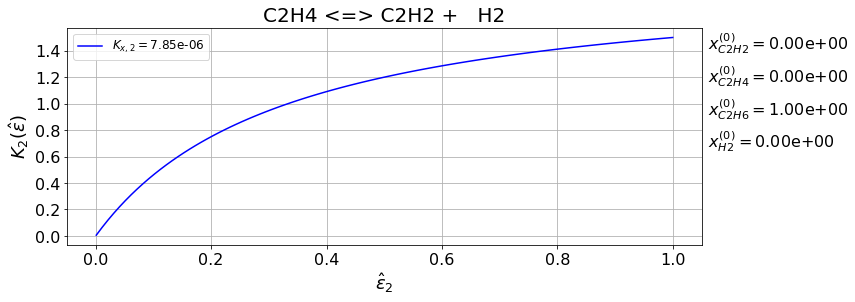

In [255]:
'''Plot equilibrium vector function'''

import numpy as np
num_keq_functions = k_x_cte_vec.size
ext_hat_vec_min = 1e-3*np.ones(num_keq_functions,dtype=np.float64)
ext_hat_vec_max = 1*np.ones(num_keq_functions,dtype=np.float64)
#ext_hat_vec_max[0] = -.49
#ext_hat_vec_max[1] = -0.55
n_pts = 100
plot_keq_function( ext_hat_vec_min, ext_hat_vec_max, n_pts, 
                   x_vec_0, k_x_cte_vec, stoic_mtrx )

## Solve for Equilibrium<a id="solve"></a>

Solve for equilibrium for the first sub-mechanism. 

In [284]:
'''Find root and equilibrium molar fractions'''

# sub-mechanism 0
if sub_mechanism_id == 0:
    ext_hat_vec_0 = 1e-4 * np.ones(len(reactions),dtype=np.float64)

# sub-mechanism 1
if sub_mechanism_id == 1:
    ext_hat_vec_0    = 1e-6 * np.ones(len(reactions),dtype=np.float64)
    ext_hat_vec_0[1] = 0.0

# sub-mechanism 2
if sub_mechanism_id == 2:
    ext_hat_vec_0    = 1e-5 * np.ones(len(reactions),dtype=np.float64)
    ext_hat_vec_0[1] = -1e-5

k_max = 50
tolerance = 1.0e-8

ext_hat_vec = newton_solve( x_vec_0, k_x_cte_vec, stoic_mtrx,
                            ext_hat_vec_0, k_max, tolerance )

x_vec = molar_fractions( ext_hat_vec, x_vec_0, stoic_mtrx )

print('')
print('(T[K],P[bar])=(%4.1f,%4.1f)\n'%(temp,pressure))
print('Equilibrium mole fractions:\n')
for (x,spc) in zip(x_vec,species):
    print('x_%s = %5.3e\n'%(spc,x))
    
assert np.all(x_vec >= 0.0)
assert abs(x_vec.sum() - 1.0) <= 1e-10



******************************************************
          Newton's Method Iterations                  
******************************************************
k |  K(e_k)  |  K'(e_k) | |del e_k| |    e_k   |convg|
------------------------------------------------------
 1 +7.852e-06 +2.221e+00 +5.000e-06  +1.118e-05  0.00
 2 +7.148e-06 +4.503e+00 +1.013e-05  +2.105e-05  0.94
 3 +1.577e-06 +3.383e+00 +1.319e-05  +3.416e-05  0.98
 4 +7.330e-07 +2.756e+00 +1.959e-05  +5.369e-05  0.96
 5 +4.720e-07 +2.320e+00 +2.974e-05  +8.338e-05  0.96
 6 +3.441e-07 +2.020e+00 +4.516e-05  +1.285e-04  0.96
 7 +2.545e-07 +1.817e+00 +6.827e-05  +1.967e-04  0.96
 8 +1.849e-07 +1.682e+00 +1.028e-04  +2.996e-04  0.96
 9 +1.323e-07 +1.592e+00 +1.546e-04  +4.541e-04  0.96
10 +9.491e-08 +1.532e+00 +2.321e-04  +6.863e-04  0.95
11 +6.979e-08 +1.493e+00 +3.483e-04  +1.035e-03  0.95
12 +5.407e-08 +1.466e+00 +5.225e-04  +1.557e-03  0.95
13 +4.500e-08 +1.448e+00 +7.837e-04  +2.341e-03  0.95
14 +4.019e-08 +1.435e

## Plot Equilibrium Point<a id="eqpt"></a> 

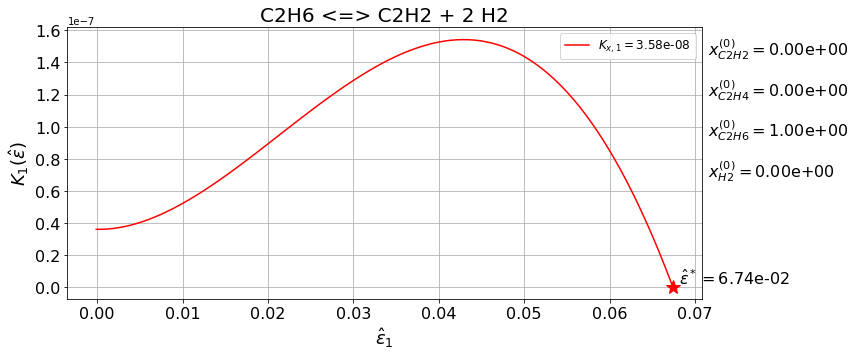

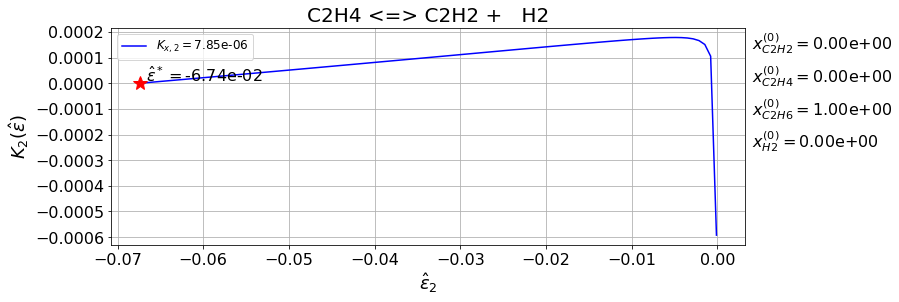

In [285]:
'''Plot equilibrium vector function'''

import numpy as np
n_keq_functions = k_x_cte_vec.size
ext_hat_vec_min = -1e-4*np.ones(n_keq_functions,dtype=np.float64)
ext_hat_vec_max = ext_hat_vec
n_pts = 100
plot_keq_function( ext_hat_vec_min, ext_hat_vec_max, n_pts, 
                   x_vec_0, k_x_cte_vec, stoic_mtrx, ext_hat_vec )

## $T$-$P$ Dependent Equilibria<a id="tpeq"></a>

Varying temperature from $800$ K to $1800$ K for three values of pressure: $1$ bar, $2$ bar, and $3$ bar. 

In [286]:
'''Loop over pressure and temperature'''

pressure_pts = [1,2,3]

# storage space
npts = 50
temp_pts      = np.linspace(800,1800,npts)
x_vec_block   = np.zeros((3,npts,len(species)))
k_x_cte_block = np.zeros((3,npts,delta_rxn_g_std_state_vec.size))
delta_rxn_h_std_state_mtrx = np.zeros((npts,delta_rxn_g_std_state_vec.size))

k_max = 50
tolerance = 1.0e-8

for p_pt in range(len(pressure_pts)):
    
    pressure = pressure_pts[p_pt]
    
    # initial guesses
    
    # sub-mechanism 0
    if sub_mechanism_id == 0:
        ext_hat_vec_0 = 1e-4 * np.ones(len(reactions),dtype=np.float64)

    # sub-mechanism 1
    if sub_mechanism_id == 1:
        ext_hat_vec_0 = 1e-6 * np.ones(len(reactions),dtype=np.float64)
        ext_hat_vec_0[1] = 0.0

    # sub-mechanism 2
    if sub_mechanism_id == 2:
        ext_hat_vec_0 = 1e-5 * np.ones(len(reactions),dtype=np.float64)
        ext_hat_vec_0[1] = -1e-5

    for t_pt in range(npts):
        
        temp = temp_pts[t_pt]
        
        # for plotting
        delta_rxn_h_std_state_mtrx[t_pt,0] = delta_rxn_h_std_state_func_vec[0](T=temp)
        delta_rxn_h_std_state_mtrx[t_pt,1] = delta_rxn_h_std_state_func_vec[1](T=temp)
        
        k_a_cte_vec = k_a_cte( temp, delta_rxn_g_std_state_vec, delta_rxn_h_std_state_func_vec )
        k_x_cte_vec = k_x_cte( pressure, stoic_mtrx, k_a_cte_vec )

        k_x_cte_block[p_pt,t_pt,:] = k_x_cte_vec # for plotting
        
        # solve
        ext_hat_vec = newton_solve( x_vec_0, k_x_cte_vec, stoic_mtrx,
                                    ext_hat_vec_0, k_max, tolerance, verbose=False )
    
        x_vec = molar_fractions( ext_hat_vec, x_vec_0, stoic_mtrx )

        print('')
        print('(T[K],P[bar])=(%4.1f,%4.1f)\n'%(temp,pressure))
        print('Equilibrium mole fractions:\n')
        for (x,spc) in zip(x_vec,species):
            print('x_%s = %5.3e\n'%(spc,x))
    
        assert np.all(x_vec >= 0.0),'x_vec=%r'%x_vec
        assert abs(x_vec.sum() - 1.0) <= 1e-10
    
        x_vec_block[p_pt,t_pt,:] = x_vec
    
        ext_hat_vec_0 = ext_hat_vec


(T[K],P[bar])=(800.0, 1.0)

Equilibrium mole fractions:

x_C2H2 = 7.850e-06

x_C2H4 = 6.312e-02

x_C2H6 = 8.737e-01

x_H2 = 6.314e-02


(T[K],P[bar])=(820.4, 1.0)

Equilibrium mole fractions:

x_C2H2 = 1.560e-05

x_C2H4 = 8.086e-02

x_C2H6 = 8.382e-01

x_H2 = 8.089e-02


(T[K],P[bar])=(840.8, 1.0)

Equilibrium mole fractions:

x_C2H2 = 2.998e-05

x_C2H4 = 1.018e-01

x_C2H6 = 7.964e-01

x_H2 = 1.018e-01


(T[K],P[bar])=(861.2, 1.0)

Equilibrium mole fractions:

x_C2H2 = 5.589e-05

x_C2H4 = 1.259e-01

x_C2H6 = 7.481e-01

x_H2 = 1.260e-01


(T[K],P[bar])=(881.6, 1.0)

Equilibrium mole fractions:

x_C2H2 = 1.013e-04

x_C2H4 = 1.529e-01

x_C2H6 = 6.938e-01

x_H2 = 1.531e-01


(T[K],P[bar])=(902.0, 1.0)

Equilibrium mole fractions:

x_C2H2 = 1.786e-04

x_C2H4 = 1.826e-01

x_C2H6 = 6.343e-01

x_H2 = 1.829e-01


(T[K],P[bar])=(922.4, 1.0)

Equilibrium mole fractions:

x_C2H2 = 3.072e-04

x_C2H4 = 2.141e-01

x_C2H6 = 5.709e-01

x_H2 = 2.147e-01


(T[K],P[bar])=(942.9, 1.0)

Equilibrium mole fr


(T[K],P[bar])=(1534.7, 2.0)

Equilibrium mole fractions:

x_C2H2 = 2.805e-01

x_C2H4 = 7.893e-02

x_C2H6 = 6.884e-04

x_H2 = 6.399e-01


(T[K],P[bar])=(1555.1, 2.0)

Equilibrium mole fractions:

x_C2H2 = 2.882e-01

x_C2H4 = 6.748e-02

x_C2H6 = 5.105e-04

x_H2 = 6.438e-01


(T[K],P[bar])=(1575.5, 2.0)

Equilibrium mole fractions:

x_C2H2 = 2.948e-01

x_C2H4 = 5.766e-02

x_C2H6 = 3.795e-04

x_H2 = 6.472e-01


(T[K],P[bar])=(1595.9, 2.0)

Equilibrium mole fractions:

x_C2H2 = 3.004e-01

x_C2H4 = 4.928e-02

x_C2H6 = 2.830e-04

x_H2 = 6.501e-01


(T[K],P[bar])=(1616.3, 2.0)

Equilibrium mole fractions:

x_C2H2 = 3.052e-01

x_C2H4 = 4.214e-02

x_C2H6 = 2.118e-04

x_H2 = 6.525e-01


(T[K],P[bar])=(1636.7, 2.0)

Equilibrium mole fractions:

x_C2H2 = 3.092e-01

x_C2H4 = 3.608e-02

x_C2H6 = 1.591e-04

x_H2 = 6.545e-01


(T[K],P[bar])=(1657.1, 2.0)

Equilibrium mole fractions:

x_C2H2 = 3.127e-01

x_C2H4 = 3.094e-02

x_C2H6 = 1.200e-04

x_H2 = 6.563e-01


(T[K],P[bar])=(1677.6, 2.0)

Equilibrium

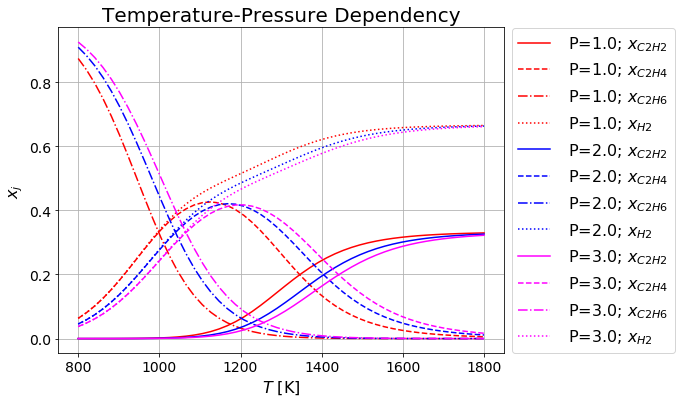

In [287]:
import matplotlib.pyplot as plt
plt.figure(1, figsize=(8, 6))

from chen_3170.help import color_map
colors = color_map(len(pressure_pts))

line_style = ['-','--','-.',':'] # for species

for p_pt in range(len(pressure_pts)):
    pressure = pressure_pts[p_pt] 
    color = colors[p_pt]
    for i in range(len(species)):
        plt.plot(temp_pts, x_vec_block[p_pt,:,i],line_style[i],color=color,label=r' P=%1.1f; $x_{%s}$'%(pressure,species[i]))

plt.xlabel(r'$T$ [K]',fontsize=16)
plt.ylabel(r'$x_j$',fontsize=16)
    
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(loc='center right',bbox_to_anchor=(1.4,0.5),fontsize=16)
  
plt.title('Temperature-Pressure Dependency',fontsize=20)
plt.grid(True)
plt.show()
print('')
    

**Observations:** the sweet spot for simultaneous production of ethylene and acetylene is at the cross over point. The cross over point at the lowest pressure occur at lower temperature, therefore lower pressure is more economical.

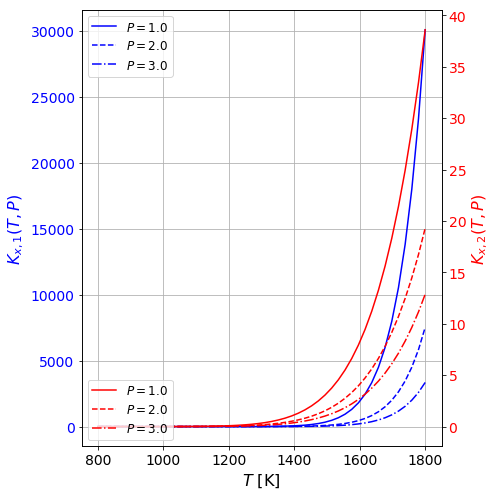

In [288]:
import matplotlib.pyplot as plt

(fig, ax1) = plt.subplots(1, figsize=(7, 7))
ax2 = ax1.twinx()

line_style = ['-','--','-.'] # pressure

for p_pt in range(len(pressure_pts)):
    
    pressure = pressure_pts[p_pt]
    
    ax1.plot(temp_pts,k_x_cte_block[p_pt,:,0],line_style[p_pt],color='blue',label=r'$P=%1.1f$'%pressure )   
    
    
    ax2.plot(temp_pts,k_x_cte_block[p_pt,:,1],line_style[p_pt],color='red',label=r'$P=%1.1f$'%pressure )

ax1.legend(loc='upper left',fontsize=12)
ax1.set_xlabel(r'$T$ [K]',fontsize=16)
ax1.set_ylabel(r'$K_{x,%i}(T,P)$'%reaction_ids[0],fontsize=16,color='blue')
ax1.tick_params(axis='y', labelcolor='blue', labelsize=14)
ax1.tick_params(axis='x', labelsize=14)
ax1.grid(True)

ax2.set_ylabel(r'$K_{x,%i}(T,P)$'%reaction_ids[1],fontsize=16,color='red')
ax2.tick_params(axis='y', labelcolor='red', labelsize=14)
ax2.tick_params(axis='x', labelsize=14)
ax2.legend(loc='lower left',fontsize=12)
#ax2.grid(True)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
#plt.grid(True)
plt.show()
print('')   

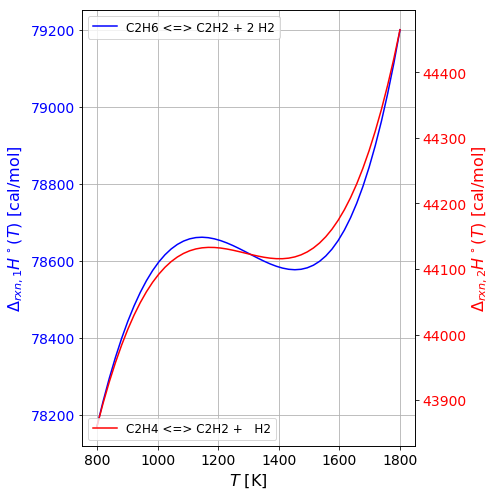

In [289]:
import matplotlib.pyplot as plt

(fig, ax1) = plt.subplots(1, figsize=(7, 7))
ax2 = ax1.twinx()
 
ax1.plot(temp_pts,delta_rxn_h_std_state_mtrx[:,0],'b-',label=reactions[0] )   
ax2.plot(temp_pts,delta_rxn_h_std_state_mtrx[:,1],'r-',label=reactions[1] )

ax1.legend(loc='upper left',fontsize=12)
ax1.set_xlabel(r'$T$ [K]',fontsize=16)
ax1.set_ylabel(r'$\Delta_{rxn,%i}H^\circ(T)$ [cal/mol]'%reaction_ids[0],fontsize=16,color='blue')
ax1.tick_params(axis='y', labelcolor='blue', labelsize=14)
ax1.tick_params(axis='x', labelsize=14)
ax1.grid(True)

ax2.set_ylabel(r'$\Delta_{rxn,%i}H^\circ(T)$ [cal/mol]'%reaction_ids[1],fontsize=16,color='red')
ax2.tick_params(axis='y', labelcolor='red', labelsize=14)
ax2.tick_params(axis='x', labelsize=14)
ax2.legend(loc='lower left',fontsize=12)
#ax2.grid(True)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
#plt.grid(True)
plt.show()
print('')   